In [1]:
# Main library: https://square.github.io/pysurvival/index.html
#----------------------------Reproducible------------------------------------------
import numpy as np
import random as rn
import pandas as pd
import gc
import os

seed=0
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
rn.seed(seed)

#----------------------------Reproducible------------------------------------------

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.model_selection import train_test_split
from pysurvival.models.semi_parametric import NonLinearCoxPHModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
from pysurvival.utils.display import display_loss_values
from pysurvival.utils.display import compare_to_actual

from lifelines import KaplanMeierFitter
from matplotlib import pyplot as plt

import heapq
import seaborn as sns

In [2]:
def csv_read(p_path):
    pd_data=pd.read_csv(p_path, sep=',')
    column_names=pd_data.columns.values.tolist()
    print(column_names)
    return pd_data,column_names

def write_to_csv(p_data,p_path):
    dataframe = pd.DataFrame(p_data)
    dataframe.to_csv(p_path, mode='a',header=False,index=False,sep=',')
    del dataframe
    gc.collect()

In [3]:
data,column_names=csv_read('./data/survival_data_filtered_3.csv')

['NACCREAS', 'NACCREFR', 'BIRTHMO', 'BIRTHYR', 'SEX', 'HISPANIC', 'HISPOR', 'RACE', 'RACESEC', 'RACETER', 'PRIMLANG', 'EDUC', 'MARISTAT', 'NACCLIVS', 'INDEPEND', 'RESIDENC', 'HANDED', 'NACCFADM', 'NACCFFTD', 'MEMORY', 'ORIENT', 'JUDGMENT', 'COMMUN', 'HOMEHOBB', 'PERSCARE', 'CDRSUM', 'DECSUB', 'DECIN', 'COGMEM', 'COGJUDG', 'COGLANG', 'COGVIS', 'COGATTN', 'COGOTHR', 'NACCCOGF', 'COGMODE', 'DECAGE', 'BEAPATHY', 'BEDEP', 'BEVHALL', 'BEAHALL', 'BEDEL', 'BEDISIN', 'BEIRRIT', 'BEAGIT', 'BEPERCH', 'BEOTHR', 'NACCBEHF', 'BEMODE', 'MOGAIT', 'MOFALLS', 'MOTREM', 'MOSLOW', 'NACCMOTF', 'MOMODE', 'COURSE', 'FRSTCHG', 'NORMCOG', 'DEMENTED', 'NACCPPA', 'NACCBVFT', 'NACCLBDS', 'NACCTMCI', 'NACCMCIL', 'NACCMCIA', 'NACCMCIE', 'NACCMCIV', 'NACCMCII', 'IMPNOMCI', 'NACCALZD', 'NACCALZP', 'NACCLBDE', 'NACCLBDP', 'PARK', 'PSP', 'PSPIF', 'CORT', 'CORTIF', 'DOWNS', 'DOWNSIF', 'HUNT', 'HUNTIF', 'PRION', 'PRIONIF', 'BRNINJ', 'BRNINJIF', 'HYCEPH', 'HYCEPHIF', 'NEOP', 'NEOPIF', 'DEP', 'DEPIF', 'OTHPSY', 'OTHPSYIF',

In [4]:
data

,NACCREAS,NACCREFR,BIRTHMO,BIRTHYR,SEX,HISPANIC,HISPOR,RACE,RACESEC,RACETER,...,NPBNKB,NACCFORM,NACCPARA,NACCCSFP,NPBNKF,NPFAUT,NACCDAGE,NACCINT,SurvivalTime,Event
0,1,8,4,1921,2,0,88,1,88,88,...,1,1,1,1,0,0,98,4,2604,False
1,1,1,3,1923,1,0,88,1,88,88,...,1,1,1,0,0,0,92,6,3000,False
2,1,8,5,1931,1,0,88,1,88,88,...,0,1,1,0,0,0,88,43,870,True
3,1,1,8,1916,2,0,88,2,3,88,...,0,1,1,0,0,0,103,34,3698,False
4,1,8,10,1942,2,0,88,1,88,88,...,0,1,1,1,0,0,76,53,720,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,1,8,8,1925,1,0,88,1,88,88,...,0,0,1,0,0,1,92,71,1438,True
332,2,8,4,1924,1,0,88,1,88,88,...,1,0,1,0,0,0,90,15,2489,True
333,1,8,6,1941,1,0,88,1,88,88,...,1,1,1,0,0,0,76,8,437,True
334,1,1,11,1938,2,0,88,1,88,88,...,1,1,1,0,0,0,76,2,1592,True


In [5]:
Events=np.array(data.loc[:,'Event'])
print("%.2f%% samples are right censored in whole data." % (np.sum(~Events) * 100. / len(Events)))

37.20% samples are right censored in whole data.


In [ ]:
X=data.loc[:,'NACCREAS':'NACCINT']
y_=data.loc[:,'SurvivalTime':'Event']
y=np.array([(y__[1],y__[0]) for y__ in np.array(y_)], dtype=[('Event', 'bool'), ('SurvivalTime', '<f8')])

models=[]
structure = [ {'activation': 'BentIdentity', 'num_units': 150},  ]
seed_num=5
epoch_num=2000

for seed_i in np.arange(seed_num):

    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=seed_i)

    time_train=y_train['SurvivalTime']
    event_train=y_train['Event']
    time_test=y_test['SurvivalTime']
    event_test=y_test['Event']

    # Building the model
    nonlinear_coxph = NonLinearCoxPHModel(structure=structure)
    nonlinear_coxph.fit(X_train, time_train, event_train, num_epochs = epoch_num,lr=1e-4, init_method='glorot_uniform')

    models.append(nonlinear_coxph)

% Completion: 100%|***********************************************|Loss: 499.48


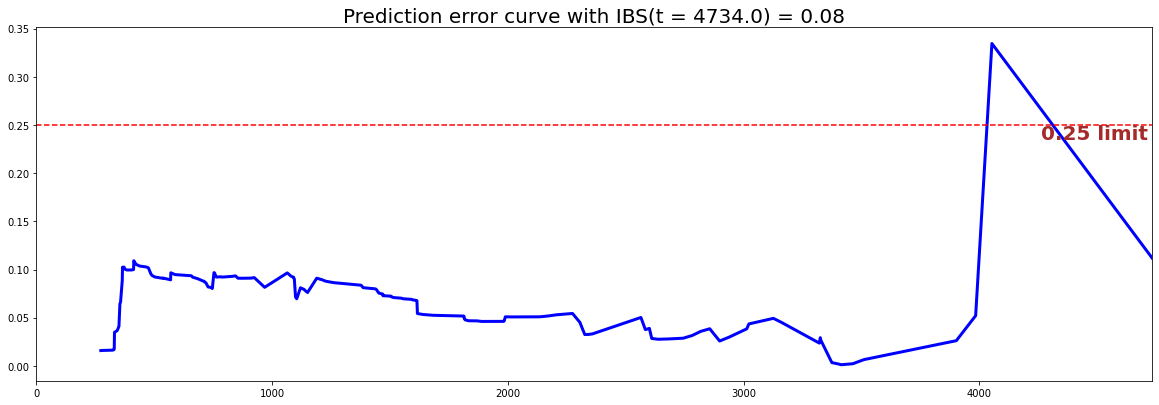

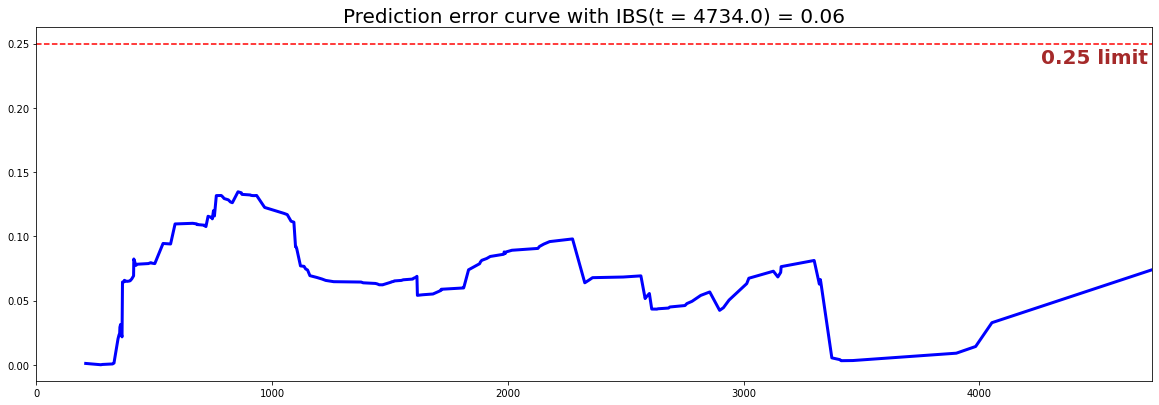

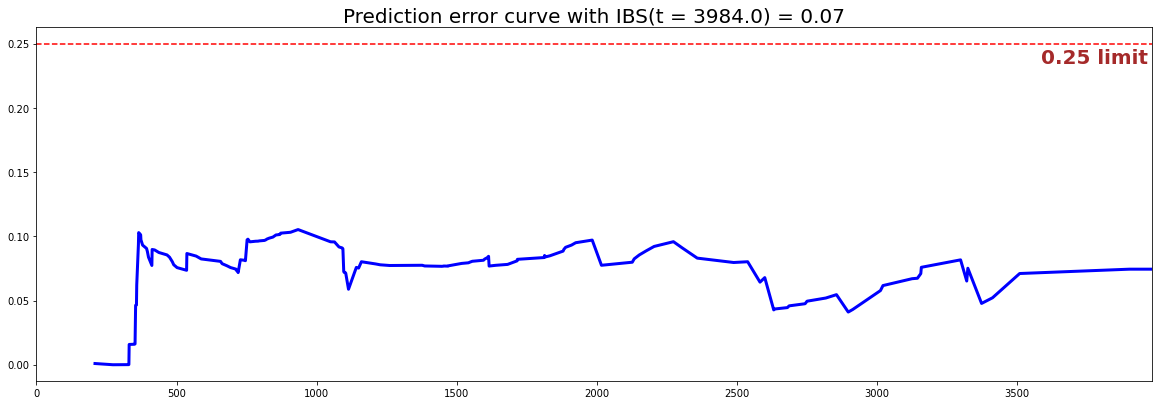

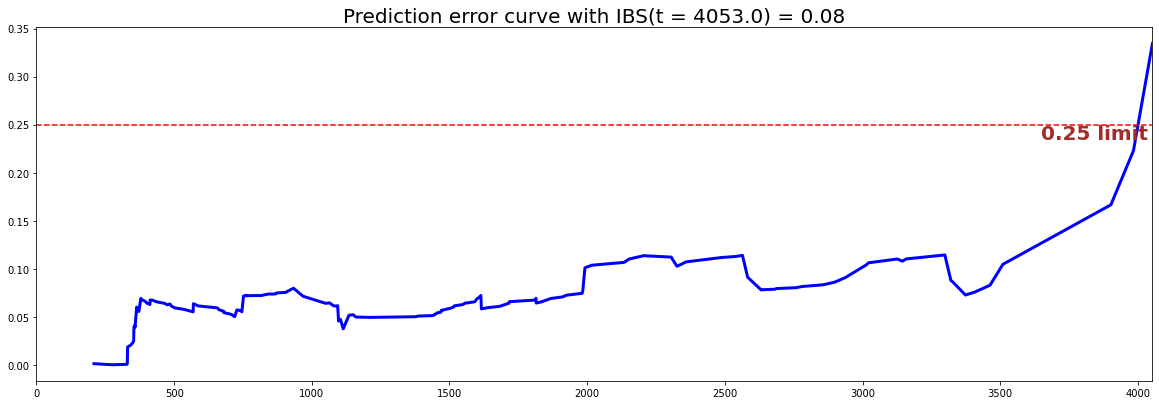

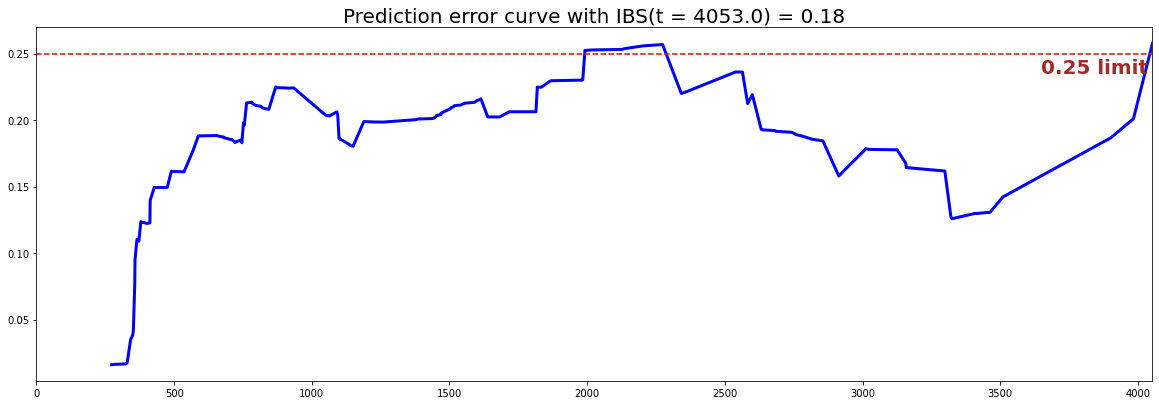

In [7]:
Loss_list=[]
C_index_list=[]
IBS_list=[]

for seed_i in np.arange(seed_num):
    model_used=models[seed_i]
    Loss_list.append(model_used.loss_values)
    
    # Model Performances
    c_index = concordance_index(model_used, X_test, time_test, event_test) #0.81
    #print('C-index: {:.2f}'.format(c_index))

    ibs = integrated_brier_score(model_used, X_test, time_test, event_test, t_max=None, figure_size=(20, 6.5) )
    #print('IBS: {:.2f}'.format(ibs))

    C_index_list.append(c_index)
    IBS_list.append(ibs)

In [8]:
p_path="./performance_CI.csv"
write_to_csv(np.array(C_index_list).reshape(1,np.array(C_index_list).shape[0]),p_path)
print(C_index_list)
print(np.mean(C_index_list))
print(np.std(C_index_list))

p_path="./performance_IBS.csv"
write_to_csv(np.array(IBS_list).reshape(1,np.array(IBS_list).shape[0]),p_path)
print(IBS_list)
print(np.mean(IBS_list))
print(np.std(IBS_list))

[0.884769640924321, 0.9021757580744336, 0.8935499153808774, 0.9062936295708429, 0.7386766894218232]
0.8650931266744596
0.0636406672413445
[0.07603191749573301, 0.0584695897184889, 0.06982067695029553, 0.0841103414300677, 0.1779316851070633]
0.09327284214032969
0.04314995023304498


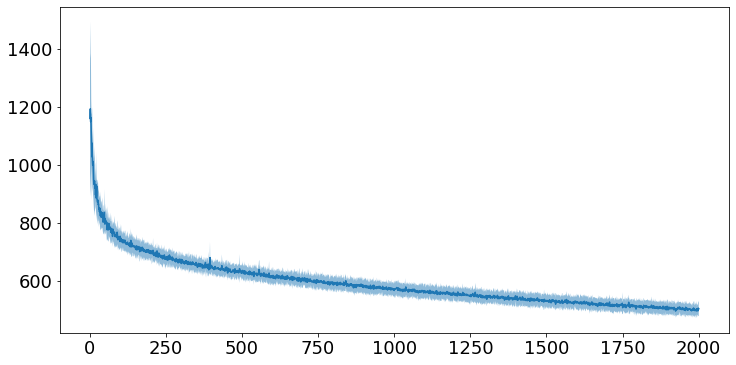

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
Loss_list_mean=np.mean(np.array(Loss_list),axis=0)
Loss_list_std=np.std(np.array(Loss_list),axis=0)

max_loss=int(np.max(Loss_list_mean))+1
min_loss=int(np.min(Loss_list_mean))
step=int(max_loss/5)

ax.plot(np.arange(epoch_num)+1, Loss_list_mean, '-')
ax.fill_between(np.arange(epoch_num)+1, Loss_list_mean - Loss_list_std, Loss_list_mean + Loss_list_std, alpha=0.5)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

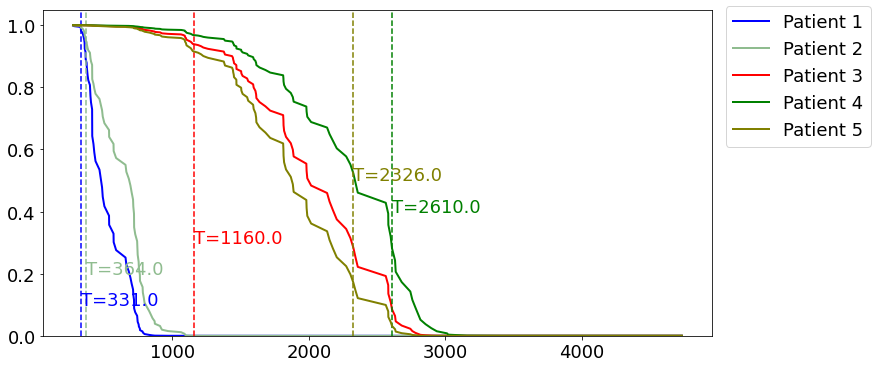

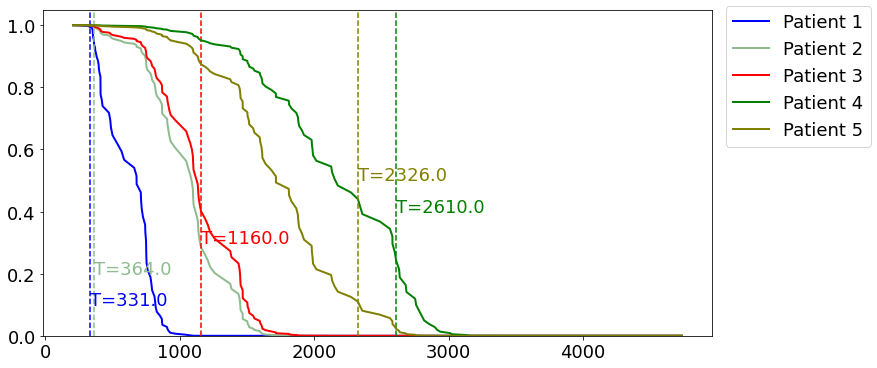

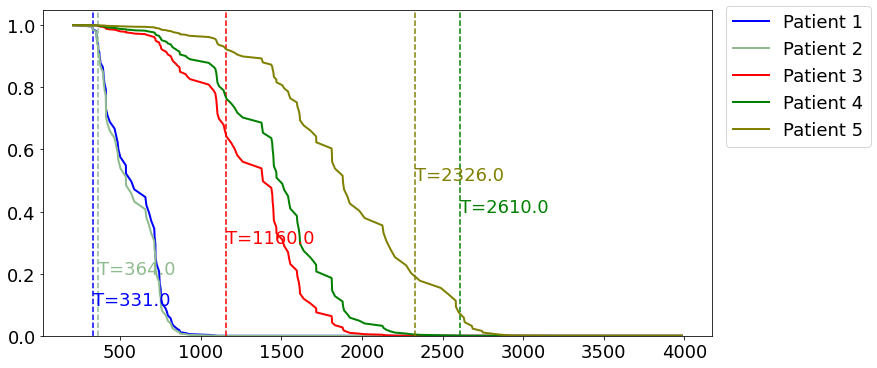

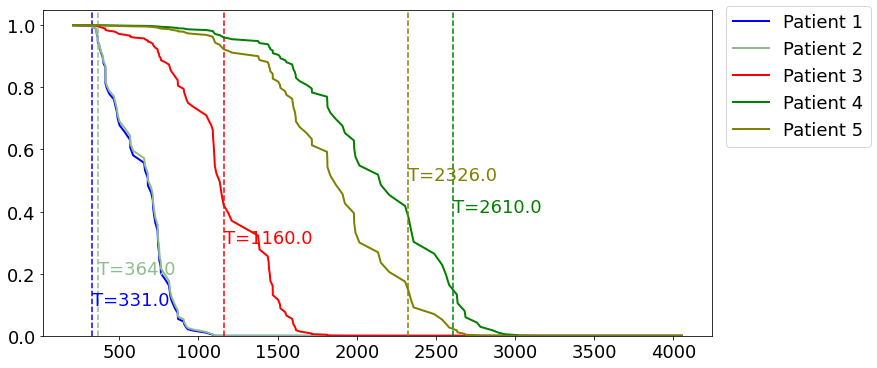

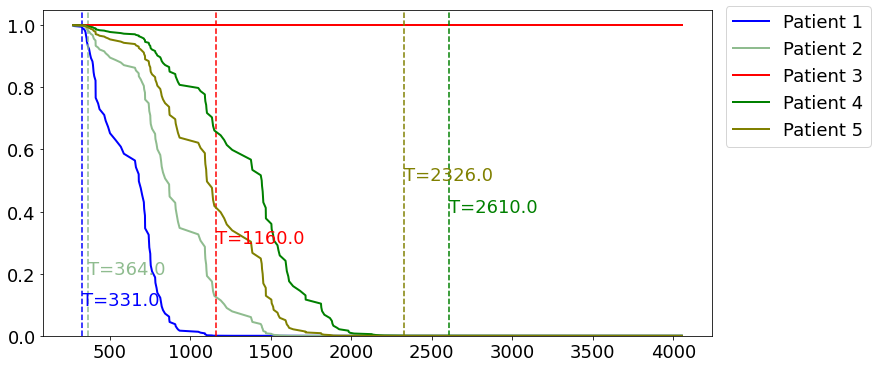

In [10]:
cs=['blue','darkseagreen','red','green','olive','cyan','tan','silver','purple','fuchsia','chocolate','darkcyan','aqua','pink','orange','bisque','lightsteelblue']

# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((event_test==1.)&(time_test>=1)).flatten()
k_list = np.random.choice( choices, 5,replace=False)

for seed_i in np.arange(seed_num):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Saving the time of event
    for i in np.arange(len(k_list)):
        k=k_list[i]
        t = time_test[k]

        # Computing the Survival function for all times t
        predicted = models[seed_i].predict_survival(X_test.values[k, :]).flatten()

        # Displaying the functions
        plt.plot(models[seed_i].times, predicted, color=cs[i], label='Patient '+str(i+1), lw=2)
    
        # Actual time
        plt.axvline(x=t, color=cs[i], ls ='--')
        ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, (0.1+i/10)), fontsize=18,color=cs[i])

    plt.legend(loc=[1.02,0.58],fontsize=18, ncol=1)
    plt.ylim(0, 1.05)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

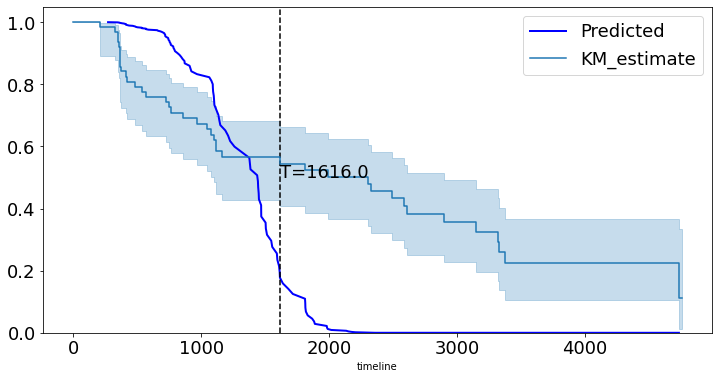

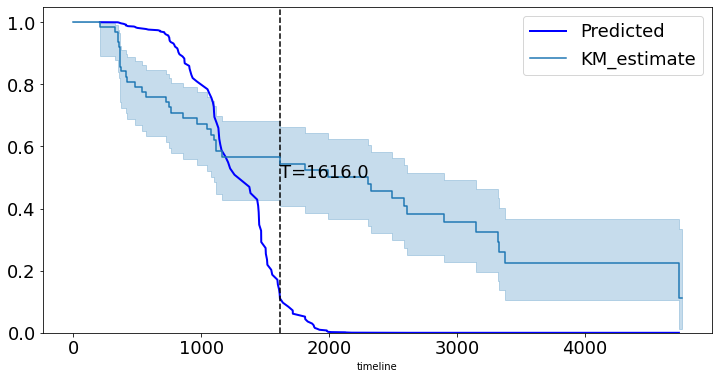

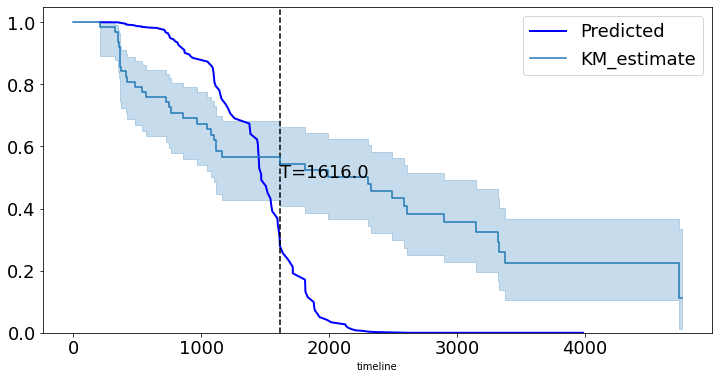

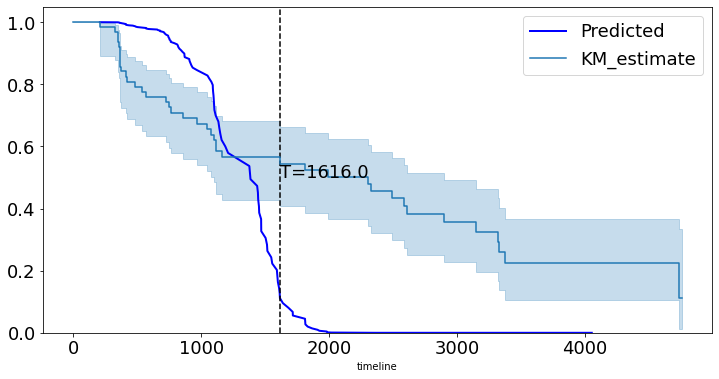

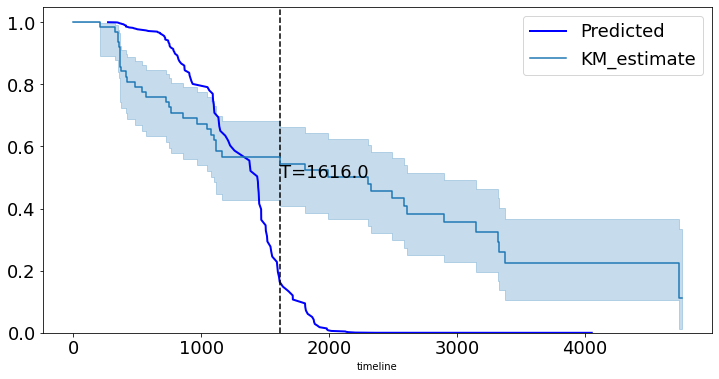

In [11]:
# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((event_test==1.)&(time_test>=1)).flatten()
k = np.random.choice( choices, 1)[0]
    
for seed_i in np.arange(seed_num):
    
    kmf = KaplanMeierFitter()
    fig, ax = plt.subplots(figsize=(12, 6))

    # Saving the time of event
    t = time_test[k]

    # Computing the Survival function for all times t
    predicted = models[seed_i].predict_survival(X_test.values[k, :]).flatten()

    # Displaying the functions
    plt.plot(models[seed_i].times, predicted, color='blue', label='Predicted', lw=2)

    # Actual time
    plt.axvline(x=t, color='black', ls ='--')
    ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, 0.5), fontsize=18)

    kmf.fit(time_test, event_observed=event_test)
    ax = kmf.plot_survival_function(ax=ax)

    # Show everything
    plt.legend(fontsize=18)
    plt.ylim(0, 1.05)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

In [12]:
# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((event_test==1.)&(time_test>=1)).flatten()
k = np.random.choice(choices, 1)[0]

# Saving the time of event
t = time_test[k]

predicted_list=[]
time_set={'Nan'}

for seed_i in np.arange(seed_num):
    # Computing the Survival function for all times t
    predicted = models[seed_i].predict_survival(X_test.values[k, :]).flatten()
    time=models[seed_i].times

    predicted_list.append(dict(zip(time,predicted)))
    time_set.update(set(time))

average_time_predicted_dict={}
for time_set_i in time_set:
    predicted_value=[]
    for seed_i in np.arange(seed_num):
        if time_set_i in predicted_list[seed_i].keys():
            predicted_value.append(predicted_list[seed_i][time_set_i])
    if len(predicted_value)>0:
        average_time_predicted_dict[time_set_i]=[np.mean(predicted_value),np.std(predicted_value)]
        
average_time_predicted={}
for i in sorted (average_time_predicted_dict.keys()) : 
    average_time_predicted[i]=average_time_predicted_dict[i]

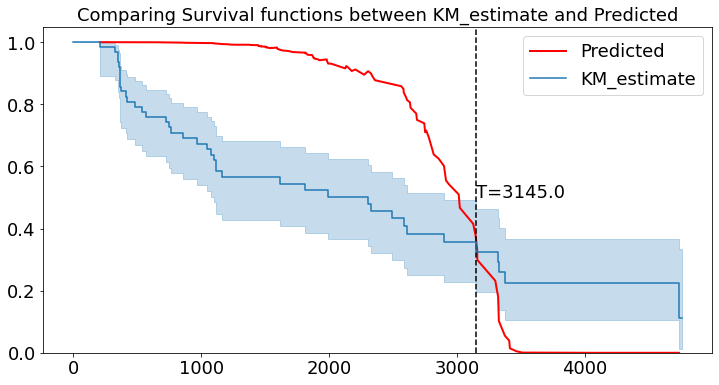

In [13]:
kmf = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(12, 6))

# Displaying the functions
plt.plot(list(average_time_predicted.keys()), np.array(list(average_time_predicted.values()))[:,0], color='red', label='Predicted', lw=2)

# Actual time
plt.axvline(x=t, color='black', ls ='--')
ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, 0.5), fontsize=18)

kmf.fit(time_test, event_observed=event_test)
ax = kmf.plot_survival_function(ax=ax)

# Show everything
title = "Comparing Survival functions between KM_estimate and Predicted"
plt.legend(fontsize=18)
plt.title(title, fontsize=18)
plt.ylim(0, 1.05)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("",fontsize=18)
plt.show()

In [14]:
models[0].model

NeuralNet(
  (model): Sequential(
    (0): Linear(in_features=243, out_features=150, bias=True)
    (1): BentIdentity()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=150, out_features=1, bias=True)
  )
)

In [15]:
feature_importace_list=[]
first_layer_weight_list=[]
for seed_i in np.arange(seed_num):
    first_layer_weight_=np.array(np.transpose(models[seed_i].model.state_dict()['model.0.weight']))
    feature_importace_=np.linalg.norm(first_layer_weight_,1, axis=1)
    first_layer_weight_list.append(first_layer_weight_)
    feature_importace_list.append(feature_importace_)

In [16]:
feature_importace=np.mean(np.array(feature_importace_list),axis=0)

In [17]:
column_names

['NACCREAS',
 'NACCREFR',
 'BIRTHMO',
 'BIRTHYR',
 'SEX',
 'HISPANIC',
 'HISPOR',
 'RACE',
 'RACESEC',
 'RACETER',
 'PRIMLANG',
 'EDUC',
 'MARISTAT',
 'NACCLIVS',
 'INDEPEND',
 'RESIDENC',
 'HANDED',
 'NACCFADM',
 'NACCFFTD',
 'MEMORY',
 'ORIENT',
 'JUDGMENT',
 'COMMUN',
 'HOMEHOBB',
 'PERSCARE',
 'CDRSUM',
 'DECSUB',
 'DECIN',
 'COGMEM',
 'COGJUDG',
 'COGLANG',
 'COGVIS',
 'COGATTN',
 'COGOTHR',
 'NACCCOGF',
 'COGMODE',
 'DECAGE',
 'BEAPATHY',
 'BEDEP',
 'BEVHALL',
 'BEAHALL',
 'BEDEL',
 'BEDISIN',
 'BEIRRIT',
 'BEAGIT',
 'BEPERCH',
 'BEOTHR',
 'NACCBEHF',
 'BEMODE',
 'MOGAIT',
 'MOFALLS',
 'MOTREM',
 'MOSLOW',
 'NACCMOTF',
 'MOMODE',
 'COURSE',
 'FRSTCHG',
 'NORMCOG',
 'DEMENTED',
 'NACCPPA',
 'NACCBVFT',
 'NACCLBDS',
 'NACCTMCI',
 'NACCMCIL',
 'NACCMCIA',
 'NACCMCIE',
 'NACCMCIV',
 'NACCMCII',
 'IMPNOMCI',
 'NACCALZD',
 'NACCALZP',
 'NACCLBDE',
 'NACCLBDP',
 'PARK',
 'PSP',
 'PSPIF',
 'CORT',
 'CORTIF',
 'DOWNS',
 'DOWNSIF',
 'HUNT',
 'HUNTIF',
 'PRION',
 'PRIONIF',
 'BRNINJ',
 'BRN

In [18]:
k=100
p_path="./feature_selection.csv"

top_k=heapq.nlargest(k, range(len(feature_importace)), feature_importace.take)

In [19]:
write_to_csv(np.array(top_k).reshape(1,np.array(top_k).shape[0]),p_path)

top_k

[109,
 9,
 108,
 105,
 27,
 22,
 220,
 12,
 20,
 59,
 241,
 230,
 113,
 68,
 136,
 174,
 73,
 54,
 0,
 235,
 234,
 44,
 31,
 157,
 131,
 134,
 4,
 10,
 16,
 62,
 67,
 233,
 150,
 192,
 1,
 175,
 39,
 21,
 102,
 11,
 190,
 129,
 36,
 25,
 41,
 135,
 43,
 23,
 69,
 216,
 202,
 78,
 126,
 50,
 228,
 166,
 167,
 26,
 70,
 122,
 143,
 19,
 182,
 168,
 121,
 95,
 133,
 123,
 163,
 125,
 215,
 128,
 159,
 124,
 75,
 144,
 90,
 74,
 212,
 103,
 34,
 65,
 140,
 98,
 13,
 53,
 29,
 97,
 32,
 107,
 114,
 199,
 183,
 132,
 92,
 101,
 55,
 56,
 42,
 127]

In [20]:
write_to_csv(feature_importace[top_k].reshape(1,feature_importace[top_k].shape[0]),p_path)

feature_importace[top_k]

array([14.628693 , 13.654986 , 12.536736 , 12.409719 , 11.499583 ,
       11.070585 , 10.750509 , 10.676096 , 10.453192 , 10.281789 ,
       10.256247 , 10.159322 , 10.15703  , 10.154195 , 10.144415 ,
       10.089695 , 10.082407 , 10.055115 ,  9.953197 ,  9.924559 ,
        9.918304 ,  9.914175 ,  9.888304 ,  9.866701 ,  9.860406 ,
        9.857281 ,  9.812906 ,  9.811883 ,  9.805852 ,  9.803119 ,
        9.782194 ,  9.779733 ,  9.770079 ,  9.769563 ,  9.737955 ,
        9.725624 ,  9.722214 ,  9.7174015,  9.699249 ,  9.698095 ,
        9.686467 ,  9.682267 ,  9.678882 ,  9.674985 ,  9.673603 ,
        9.667096 ,  9.6508665,  9.638574 ,  9.625613 ,  9.614736 ,
        9.614168 ,  9.60537  ,  9.568903 ,  9.567407 ,  9.56616  ,
        9.554993 ,  9.543271 ,  9.517947 ,  9.517217 ,  9.516628 ,
        9.503721 ,  9.499559 ,  9.498719 ,  9.488417 ,  9.487233 ,
        9.48598  ,  9.467738 ,  9.4676485,  9.463694 ,  9.455884 ,
        9.451738 ,  9.449793 ,  9.449116 ,  9.442034 ,  9.4400

In [21]:
write_to_csv(np.array(column_names[:-2])[top_k].reshape(1,np.array(column_names[:-2])[top_k].shape[0]),p_path)

np.array(column_names[:-2])[top_k]

array(['NACCAGE', 'RACETER', 'NACCIDEM', 'NACCAGEB', 'DECIN', 'COMMUN',
       'NPPDXE', 'MARISTAT', 'ORIENT', 'NACCPPA', 'NACCDAGE', 'NACCDOWN',
       'NPPMIH', 'IMPNOMCI', 'NPADNC', 'NACCARTE', 'PARK', 'MOMODE',
       'NACCREAS', 'NPBNKB', 'NACCBNKF', 'BEAGIT', 'COGVIS', 'NACCINF',
       'NPHIST', 'NACCBRAA', 'SEX', 'PRIMLANG', 'HANDED', 'NACCTMCI',
       'NACCMCII', 'NACCOTHP', 'NPINF3B', 'NPFTDTAU', 'NACCREFR', 'NPWMR',
       'BEVHALL', 'JUDGMENT', 'NACCETPR', 'EDUC', 'NPNLOSS', 'NPHISG',
       'DECAGE', 'CDRSUM', 'BEDEL', 'NACCNEUR', 'BEIRRIT', 'HOMEHOBB',
       'NACCALZD', 'NPPDXA', 'NPFTDT10', 'DOWNS', 'NPASAN', 'MOFALLS',
       'NPPDXM', 'NPOLD4', 'NACCMICR', 'DECSUB', 'NACCALZP', 'NPGRLCH',
       'NPINF1D', 'MEMORY', 'NPPATH6', 'NPOLDD', 'NPGRSNH', 'ALCDEMIF',
       'NPTHAL', 'NACCAVAS', 'NPOLD1', 'NPABAN', 'NPTDPE', 'NPHISMB',
       'NPHEMO1', 'NPTAN', 'PSPIF', 'NPINF1F', 'DEP', 'PSP', 'NPTDPB',
       'NACCADMU', 'NACCCOGF', 'NACCMCIE', 'NPINF', 'MEDS', 'NACCLIVS'

In [22]:
np.array(column_names[:-2]).shape

(243,)

In [23]:
first_layer_weight=np.mean(np.array(first_layer_weight_list),axis=0)

In [24]:
first_layer_weight.shape

(243, 150)

In [25]:
first_layer_weight

array([[ 0.01862451,  0.01387346,  0.04191601, ..., -0.03555343,
        -0.00466695, -0.01510269],
       [ 0.00711181,  0.04050796, -0.02567603, ...,  0.07478411,
         0.02227688,  0.01160463],
       [-0.04145826, -0.04050614, -0.00225258, ...,  0.01913004,
        -0.06841889,  0.02713186],
       ...,
       [-0.05103142, -0.00516296,  0.03177742, ..., -0.06820749,
        -0.00444778, -0.00174495],
       [-0.01168543,  0.03829532,  0.04304206, ..., -0.02092904,
         0.0539848 ,  0.00387568],
       [-0.06227229, -0.01568418, -0.0376084 , ...,  0.03834905,
        -0.03903944, -0.00604528]], dtype=float32)

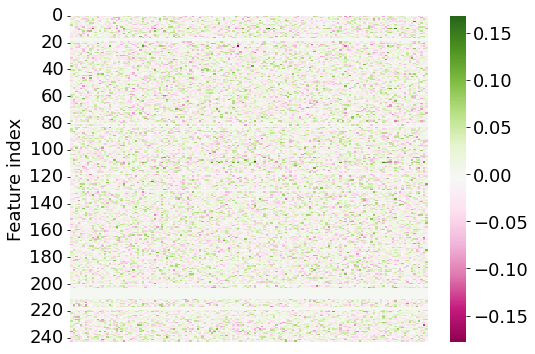

In [26]:
mn, mx = first_layer_weight.min(), first_layer_weight.max()

fig, ax = plt.subplots(figsize = (8,6))
heatmp=sns.heatmap(first_layer_weight, cmap='PiYG')
cbar = heatmp.collections[0].colorbar
# here set the labelsize by 18
cbar.ax.tick_params(labelsize=18)
plt.xlabel('')
plt.xticks([])
plt.yticks(np.arange(0,np.array(column_names[:-2]).shape[0],20),np.arange(0,np.array(column_names[:-2]).shape[0],20),fontsize=18)
plt.ylabel('Feature index',fontsize=18)
plt.show()

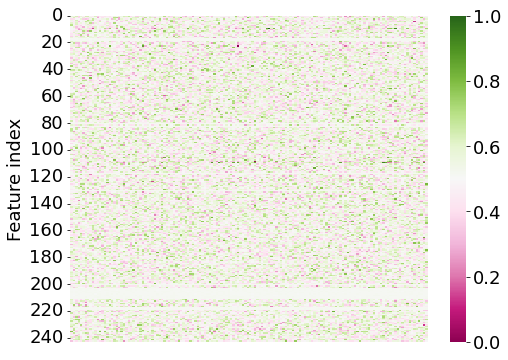

In [27]:
mn, mx = first_layer_weight.min(), first_layer_weight.max()
first_layer_weight_scaled = (first_layer_weight - mn) / (mx - mn)

fig, ax = plt.subplots(figsize = (8,6))
heatmp=sns.heatmap(first_layer_weight_scaled, cmap='PiYG', vmin=0, vmax=1)
cbar = heatmp.collections[0].colorbar
# here set the labelsize by 18
cbar.ax.tick_params(labelsize=18)
plt.xlabel('')
plt.xticks([])
plt.yticks(np.arange(0,np.array(column_names[:-2]).shape[0],20),np.arange(0,np.array(column_names[:-2]).shape[0],20),fontsize=18)
plt.ylabel('Feature index',fontsize=18)
plt.show()